## Method 2

Apply TextRank algorithm to source document and find corresponding translations in second language

### Import required libraries

In [6]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
import re

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Part 1 : Summarization

### Reading the data

In [1]:
with open('./deu.txt', encoding='utf-8') as f:
    text = f.read()

In [2]:
deu_eng = text.strip().split('\n')
deu_eng = [i.split('\t') for i in deu_eng]
#deu_eng = np.array(deu_eng)

In [3]:
deu_eng_dict = {english: german for english,german in  deu_eng}

In [4]:
deu_eng_dict

{'Hi.': 'Grüß Gott!',
 'Run!': 'Lauf!',
 'Wow!': 'Donnerwetter!',
 'Fire!': 'Feuer!',
 'Help!': 'Zu Hülf!',
 'Stop!': 'Stopp!',
 'Wait!': 'Warte!',
 'Go on.': 'Mach weiter.',
 'Hello!': 'Hallo!',
 'I ran.': 'Ich rannte.',
 'I see.': 'Aha.',
 'I try.': 'Ich probiere es.',
 'I won!': 'Ich habe gewonnen!',
 'Smile.': 'Lächeln!',
 'Cheers!': 'Zum Wohl!',
 'Freeze!': 'Stehenbleiben!',
 'Got it?': 'Einverstanden?',
 'He ran.': 'Er lief.',
 'Hop in.': 'Mach mit!',
 'Hug me.': 'Umarme mich!',
 'I fell.': 'Ich bin gestürzt.',
 'I know.': 'Ich weiß.',
 'I lied.': 'Ich habe gelogen.',
 'I lost.': 'Ich habe verloren.',
 'I paid.': 'Ich zahlte.',
 'I sang.': 'Ich sang.',
 'I swim.': 'Ich schwimme.',
 "I'm 19.": 'Ich bin 19.',
 "I'm OK.": 'Es geht mir gut.',
 "I'm up.": 'Ich bin auf.',
 'No way!': 'In keinster Weise!',
 'Really?': 'Im Ernst?',
 'Thanks.': 'Danke!',
 'Try it.': 'Versuch’s!',
 'We won.': 'Wir haben gewonnen.',
 'Why me?': 'Warum ich?',
 'Ask Tom.': 'Fragt Tom!',
 'Awesome!': 'Fantasti

In [5]:
sentences = []
for i in range(50):
    sentences.append(deu_eng[i][0])

### GloVe Word Embeddings

In [7]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [8]:
len(word_embeddings)

400000

### Text Preprocessing

In [9]:
# remove punctuations, numbers and special characters
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences = [s.lower() for s in clean_sentences]

In [11]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [13]:
# remove stopwords from the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

### Vector representation of sentences

In [14]:
sentence_vectors = []
for i in clean_sentences:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)

### Similarity matrix preparation

https://arxiv.org/pdf/1602.03606.pdf

In [15]:
# similarity matrices
sim_mat_1 = np.zeros([len(sentences), len(sentences)])
sim_mat_2 = np.zeros([len(sentences), len(sentences)])
sim_mat_3 = np.zeros([len(sentences), len(sentences)])
sim_mat_4 = np.zeros([len(sentences), len(sentences)])

In [16]:
from sklearn.metrics.pairwise import cosine_similarity, pairwise_kernels, manhattan_distances, euclidean_distances

#### 1. Cosine Similarity
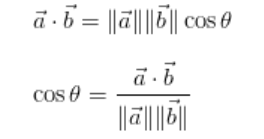

In [17]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat_1[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

#### 2. Manhattan Distance
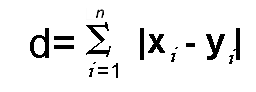

In [18]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat_2[i][j] = manhattan_distances(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

#### 3. Euclidean Distance
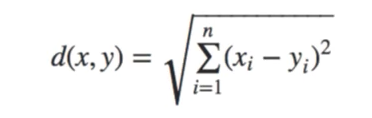

In [19]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat_3[i][j] = euclidean_distances(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

#### 4. Pairwise Kernels
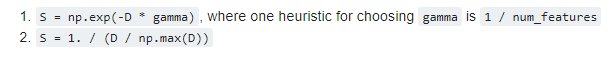

In [20]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat_4[i][j] = pairwise_kernels(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]

### Applying PageRank Algorithm

In [21]:
import networkx as nx

#### 1. Cosine Similarity

In [23]:
nx_graph_1 = nx.from_numpy_array(sim_mat_1)
scores_1 = nx.pagerank(nx_graph_1)

#### 2. Manhattan Distance

In [24]:
nx_graph_2 = nx.from_numpy_array(sim_mat_2)
scores_2 = nx.pagerank(nx_graph_2)

#### 3. Euclidean Distance

In [25]:
nx_graph_3 = nx.from_numpy_array(sim_mat_3)
scores_3 = nx.pagerank(nx_graph_3)

#### 4. Pairwise Kernels

In [26]:
nx_graph_4 = nx.from_numpy_array(sim_mat_4)
scores_4 = nx.pagerank(nx_graph_4)

### Summary Extraction

#### 1. Cosine Similarity

In [27]:
ranked_sentences_1 = sorted(((scores_1[i],s) for i,s in enumerate(sentences)), reverse=True)

test_1 = []
# Extract top 10 sentences as the summary
for i in range(10):
    test_1.append(ranked_sentences_1[i][1])

In [28]:
test_1

['Go on.',
 'Got it?',
 'Got it?',
 'Got it?',
 'No way!',
 'I know.',
 'I see.',
 'I see.',
 'Wait!',
 'Stop!']

#### 2. Manhattan Distance

In [29]:
ranked_sentences_2 = sorted(((scores_2[i],s) for i,s in enumerate(sentences)), reverse=True)

test_2 = []
# Extract top 10 sentences as the summary
for i in range(10):
    test_2.append(ranked_sentences_2[i][1])

In [30]:
test_2

['I lied.',
 'I sang.',
 'Hop in.',
 'I swim.',
 'Cheers!',
 'Freeze!',
 'Freeze!',
 'Hi.',
 'Hi.',
 'Wow!']

#### 3. Euclidean Distance

In [31]:
ranked_sentences_3 = sorted(((scores_3[i],s) for i,s in enumerate(sentences)), reverse=True)

test_3 = []
# Extract top 10 sentences as the summary
for i in range(10):
    test_3.append(ranked_sentences_3[i][1])

In [32]:
test_3

['I lied.',
 'I sang.',
 'Cheers!',
 'Hi.',
 'Hi.',
 'Hop in.',
 'I swim.',
 'Freeze!',
 'Freeze!',
 'Fire!']

#### 4. Pairwise Kernels

In [33]:
ranked_sentences_4 = sorted(((scores_4[i],s) for i,s in enumerate(sentences)), reverse=True)

test_4 = []
# Extract top 10 sentences as the summary
for i in range(10):
    test_4.append(ranked_sentences_4[i][1])

In [34]:
test_4

['Go on.',
 'Got it?',
 'Got it?',
 'Got it?',
 'I know.',
 'No way!',
 'I see.',
 'I see.',
 'Help!',
 'Help!']

### Calculating BLEU Score

In [35]:
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu

In [36]:
# Tokenizing the original sentences to calculate score
sen = []
for s in sentences:
    sen.append(word_tokenize(s))

#### 1. Cosine Similarity

In [37]:
test_sen_1 = []
for t in test_1:
    test_sen_1.append(word_tokenize(t))
test_sen_1 = [y for x in test_sen_1 for y in x] # flatten list

In [38]:
bleu_score_1 = sentence_bleu(sen, test_sen_1)
print(bleu_score_1)

5.553057155208292e-78


c:\users\chesh\appdata\local\programs\python\python36\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


#### 2. Manhattan Distance

In [39]:
test_sen_2 = []
for t in test_2:
    test_sen_2.append(word_tokenize(t))
test_sen_2 = [y for x in test_sen_2 for y in x] # flatten list

In [40]:
bleu_score_2 = sentence_bleu(sen, test_sen_2)
print(bleu_score_2)

5.699690702988605e-78


#### 3. Euclidean Distance

In [41]:
test_sen_3 = []
for t in test_3:
    test_sen_3.append(word_tokenize(t))
test_sen_3 = [y for x in test_sen_3 for y in x] # flatten list

In [42]:
bleu_score_3 = sentence_bleu(sen, test_sen_3)
print(bleu_score_3)

5.699690702988605e-78


#### 4. Pairwise Kernels

In [43]:
test_sen_4 = []
for t in test_4:
    test_sen_4.append(word_tokenize(t))
test_sen_4 = [y for x in test_sen_4 for y in x] # flatten list

In [44]:
bleu_score_4 = sentence_bleu(sen, test_sen_4)
print(bleu_score_4)

5.333825857519833e-78


## Part 2 : Translation

#### 1. Cosine Similarity

In [46]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_1[i][1]])

Mach weiter.
Einverstanden?
Einverstanden?
Einverstanden?
In keinster Weise!
Ich weiß.
Aha.
Aha.
Warte!
Stopp!


#### 2. Manhattan Distance

In [47]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_2[i][1]])

Ich habe gelogen.
Ich sang.
Mach mit!
Ich schwimme.
Zum Wohl!
Stehenbleiben!
Stehenbleiben!
Grüß Gott!
Grüß Gott!
Donnerwetter!


#### 3. Euclidean Distance

In [48]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_3[i][1]])

Ich habe gelogen.
Ich sang.
Zum Wohl!
Grüß Gott!
Grüß Gott!
Mach mit!
Ich schwimme.
Stehenbleiben!
Stehenbleiben!
Feuer!


#### 4. Pairwise Kernels

In [49]:
# Extract top 10 sentences as the summary
for i in range(10):
    print(deu_eng_dict[ranked_sentences_4[i][1]])

Mach weiter.
Einverstanden?
Einverstanden?
Einverstanden?
Ich weiß.
In keinster Weise!
Aha.
Aha.
Zu Hülf!
Zu Hülf!
